# Task 3: Unconditional Generation with DDPM
### *EE 367, Stanford University*

In this task, you will implement unconditional image generation using a pre-trained DDPM. You'll learn how diffusion models
can generate new images from pure noise through an iterative denoising process.

Your tasks:
- Understand the reverse sampling process in diffusion models
- Implement iterative denoising for image generation
- Generate and visualize new images from random noise
- Qualitatively evaluate the generated image results

*Note:* Some helper functions are provided for you. Focus on implementing
the marked sections.

Before you begin:
1. Download the folder `diffusion_project`
2. Upload the folder to your Google Drive
3. Change runtime type to "T4 GPU" (click the drop-down button in the top right corner of this page for "Additional connection options" then click "change runtime type", change to "T4 GPU" and save)

## Connect to your Google Drive to access `diffusion_project` and setup model environment

This section handles the necessary setup steps to run diffusion models in Google Colab:
1. Connects to Google Drive to access project files
2. Imports required libraries
3. Loads the pretrained diffusion model and supporting components

The model is pretrained on FFHQ-256 dataset.

In [15]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/diffusion_project/" # Replace with your path to the diffusion_project folder
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

# Import required packages
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from functools import partial

from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import get_named_beta_schedule
from util.img_utils import clear_color
from util.logger import get_logger
from util.img_utils import Blurkernel

from PIL import Image
import numpy as np
from tqdm.auto import tqdm

from skimage.metrics import peak_signal_noise_ratio as psnr
from util.setup_env import setup_diffusion_environment

# Initialize the diffusion environment
setup = setup_diffusion_environment()

# Extract components
model = setup['model']
device = setup['device']
logger = setup['logger']


2025-03-11 20:25:13,027 [DPS] >> Device set to cuda:0.
2025-03-11 20:25:13,027 [DPS] >> Device set to cuda:0.
2025-03-11 20:25:13,027 [DPS] >> Device set to cuda:0.
INFO:DPS:Device set to cuda:0.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/diffusion_project


## Initialize DDPM parameters
Initialize the key parameters needed for the diffusion process. These parameters control how noise is added and removed during the diffusion steps.

In [16]:
num_timesteps = 1000 # Total number of noise steps
betas = get_named_beta_schedule(schedule_name="linear", num_diffusion_timesteps=num_timesteps)

alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = (1.0 - alphas_cumprod) / np.sqrt(alphas_cumprod)

posterior_mean_coef1 = betas * np.sqrt(alphas_cumprod_prev) / (1.0-alphas_cumprod)
posterior_mean_coef2 = (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod)

posterior_variance = (
    betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
)
posterior_log_variance_clipped = np.log(
    np.append(posterior_variance[1], posterior_variance[1:])
)

## Define helper functions

This section defines utility functions needed for the diffusion process. Make use of the helper functions in your implementation.

In [17]:
def extract_and_expand(array, time, target):
    """
    Extract values from an array at specified timesteps and expand to match target shape.

    Args:
        array: Source array containing coefficient values
        time: Timestep indices to extract
        target: Tensor whose shape we want to match

    Returns:
        Expanded tensor matching target shape with values from array at specified times
    """
    array = torch.from_numpy(array).to(target.device)[time].float()
    while array.ndim < target.ndim:
        array = array.unsqueeze(-1)
    return array.expand_as(target)

def get_variance(x, t):
    """
    Calculate the variance of the posterior distribution at timestep t.

    Args:
        x: Input tensor containing model's variance predictions
        t: Current timestep indices

    Returns:
        Log variance interpolated between min and max values based on model prediction
    """
    model_var_values = x
    min_log = posterior_log_variance_clipped
    max_log = np.log(betas)

    # Extract and expand variance bounds
    min_log = extract_and_expand(min_log, t, x)
    max_log = extract_and_expand(max_log, t, x)

    # Interpolate between min and max variance (model_var_values is in [-1, 1])
    frac = (model_var_values + 1.0) / 2.0
    model_log_variance = frac * max_log + (1-frac) * min_log
    return model_log_variance

def process_xstart(x):
    """
    Clamp predicted x_0 values to valid range.

    Args:
        x: Input tensor to be processed

    Returns:
        Tensor with values clamped to [-1, 1] range
    """
    x = x.clamp(-1, 1)
    return x

## Define one step of sampling (i.e. calculate $\hat{x_0}$ and $x_{t-1}$)

This section implements the core sampling functions for the reverse diffusion process.
It contains three main components:

1. Single-step denoising (`denoise`): Predicts x_0 from noisy x_t (*same as task 1, you can copy and paste the denoise() function you implemented before*)
2. Posterior mean calculation (`q_posterior_mean`): Computes q(x_{t-1} | x_t, x_0)
3. Sampling step (`p_sample`): Performs one complete step of the reverse diffusion

These functions work together to gradually transform random noise into meaningful images.

In [18]:
def denoise(x_t, t, eps):
    """
    Perform single-step denoising using the predicted noise.
    i.e. x_0_hat from the DPS paper

    Args:
        x_t: Noisy image at timestep t
        t: Current timestep
        eps: Predicted noise from the model

    Returns:
        Denoised image prediction using the diffusion model equation
    """

    score = - eps / np.sqrt(1.0 - alphas_cumprod[t])

    ############### begin: complete the following code section  ###############
    x_0_hat = 1 / np.sqrt(alphas_cumprod[t]) * (x_t + (1 - alphas_cumprod[t]) * score)
    return process_xstart(x_0_hat)
    # return x_0_hat
    ############### end: complete the following code section  ###############

def q_posterior_mean(x_start, x_t, t):
    """
    Compute the mean of the diffusion posterior: q(x_{t-1} | x_t, x_0)

    Args:
        x_start: Predicted clean image (x_0)
        x_t: Current noisy image
        t: Current timestep

    Returns:
        Mean of the posterior distribution
    """
    assert x_start.shape == x_t.shape

    ############### begin: complete the following code section  ###############
    # coef1 = extract_and_expand(posterior_mean_coef1, t, x_t)
    # coef2 = extract_and_expand(posterior_mean_coef2, t, x_t)
    # mean = coef1 * x_start + coef2 * x_t
    mean = posterior_mean_coef1[t] * x_start + posterior_mean_coef2[t] * x_t
    return mean

    ############### end: complete the following code section  ###############

def p_sample(model, x, t):
    """
    Perform one complete step of the sampling process.

    Args:
        model: The DDPM model
        x: Current noisy image
        t: Current timestep

    Returns:
        Dictionary containing:
        - sample: Next image in sequence (x_{t-1})
        - pred_xstart: Predicted clean image (x_0)
    """
    model_output = model(x, t)

    # Split into noise and variance predictions
    model_output, model_var_values = torch.split(model_output, x.shape[1], dim=1)

    # Predict x_0 and prepare for next step
    x_0_hat = process_xstart(denoise(x, t, model_output))
    x_t = q_posterior_mean(x_0_hat, x, t)

    # Add sampling noise scaled by predicted variance (except at t=0)
    noise = torch.randn_like(x)
    model_log_variance = get_variance(model_var_values, t)

    if t != 0:  # no noise when t == 0
        x_t += torch.exp(0.5 * model_log_variance) * noise

    return {'sample': x_t, 'pred_xstart': x_0_hat}

## Implement sampling loop for unconditional generation

This section implements the complete reverse diffusion sampling process.
Starting from pure noise, it iteratively denoises the image through all timesteps
to generate the final sample. It also includes optional progress visualization.

In [19]:
def unconditional_generation(model, x_start, record, save_root):

    img = x_start
    pbar = tqdm(list(range(num_timesteps))[::-1])

    device = x_start.device

    for idx in pbar:
        time = torch.tensor([idx] * img.shape[0], device=device)

        img = img.requires_grad_()

        ############### begin: complete the following code section  ###############
        img = p_sample(model, img, time)['sample']

        ############### end: complete the following code section  ###############

        img = img.detach_()

        if record:
            if idx % 10 == 0:
                file_path = os.path.join(save_root, f"progress/x_{str(idx).zfill(4)}.png")
                plt.imsave(file_path, clear_color(img))

    return img

## Test unconditional generation

Use the function you implemented `unconditional_generation()` to generate an image from noise. Every time you run this section, it should give a different generated image.

In [20]:
out_path = "results/"

############### begin: complete the following code section  ###############
os.makedirs(out_path, exist_ok=True)

# Initialize with Gaussian noise
img = Image.open('data/samples/00014.png').convert('RGB') # Replace with your choice of test image
# print(img)
x_start = torch.randn((1, 3, 256, 256), device=device)

# Generate image
sample = unconditional_generation(model, x_start, record=True, save_root=out_path)

############### end: complete the following code section  ###############

  0%|          | 0/1000 [00:00<?, ?it/s]

## Visualize the results

Qualitatively evaluate the generated image. Does it look like a sample from the training dataset (i.e. human face)?

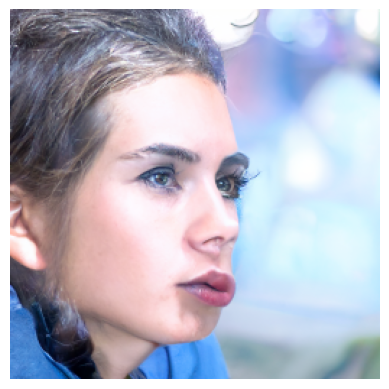

In [21]:
plt.imsave(out_path + f'uncond_generation.png', clear_color(sample))
plt.tight_layout()
plt.axis('off')
plt.imshow(clear_color(sample))